In [1]:
# load library

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statistics
import pickle
import functools


from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, Constraint)
from ema_workbench import load_results
from ema_workbench.analysis import prim, dimensional_stacking, cart
from ema_workbench.util import ema_logging, utilities

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties, MonteCarloSampler
ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\na0e2\Miniconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


<Logger EMA (DEBUG)>

In [2]:
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation

results = utilities.load_results('results/base_case_75.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)

outcome_total = pd.read_csv('results/75policies_with_total_values.csv')


results = experiments.join(outcome_total)
results = results.drop(columns="model")
results

[MainProcess/INFO] results loaded succesfully from C:\Users\na0e2\Documents\EPA1361\epa1361_open-master\final assignment\results\base_case_75.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2,Total Expected Annual Damage,Total Expected Number of Deaths,Total Dike Investment Costs,Total RfR Total Costs,Total Expected Evacuation Costs
0,22.0,316.720229,1.5,0.508918,179.556360,1.0,0.056675,161.786225,1.0,0.411000,...,0.0,9.630148e+07,0.0,492600000.0,0.000000,1.704003e+07,0.002139,5.571625e+08,1.069800e+09,737.296215
1,37.0,48.449390,1.5,0.726517,71.388513,1.0,0.316716,140.869331,10.0,0.288527,...,0.0,9.630148e+07,0.0,492600000.0,0.000000,2.788806e+07,0.004377,5.571625e+08,1.069800e+09,1125.312347
2,116.0,342.466577,1.5,0.696968,164.240184,10.0,0.070253,241.641985,10.0,0.701739,...,0.0,9.630148e+07,0.0,492600000.0,0.000000,3.106400e+06,0.000434,5.571625e+08,1.069800e+09,240.005210
3,131.0,317.750054,10.0,0.514734,41.084696,10.0,0.670645,172.060501,1.5,0.002929,...,0.0,9.630148e+07,0.0,492600000.0,568.536776,6.589090e+08,0.125879,5.571625e+08,1.069800e+09,38728.384144
4,69.0,134.031006,1.0,0.056991,141.114722,10.0,0.138095,275.399627,1.0,0.807559,...,0.0,9.630148e+07,0.0,492600000.0,0.000000,1.957596e+07,0.003175,5.571625e+08,1.069800e+09,2151.356713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,23.0,151.955766,10.0,0.943525,149.089915,1.5,0.594206,270.182770,1.5,0.089715,...,0.0,5.525012e+07,0.0,679700000.0,0.000000,1.040420e+08,0.019924,7.619611e+08,1.474700e+09,5788.122696
74996,39.0,224.496227,1.0,0.390712,243.949795,1.0,0.090980,310.542851,1.5,0.569246,...,0.0,5.525012e+07,0.0,679700000.0,0.000000,8.310638e+07,0.008613,7.619611e+08,1.474700e+09,5271.800704
74997,45.0,347.284444,1.0,0.687342,59.820104,1.0,0.659417,229.083131,1.0,0.643934,...,0.0,5.525012e+07,0.0,679700000.0,0.000000,3.193923e+06,0.000458,7.619611e+08,1.474700e+09,244.787029
74998,124.0,106.585076,1.0,0.434781,132.822331,10.0,0.266128,170.757239,10.0,0.151776,...,0.0,5.525012e+07,0.0,679700000.0,0.000000,5.805561e+07,0.007140,7.619611e+08,1.474700e+09,2567.922822


In [61]:
# minimise the worst outcome and minimise the standard deviation
#defined as the median value multiplied by the interquartile distance plus one

def robustness(result):
    mean = np.median(result)
    iqr = sp.stats.iqr(result) + 1 #to aviod the return being 0
    robust = mean * iqr
    return robust

def total_robustness(*result):

    total_robust = robustness(sum(result))

    return total_robust


In [62]:
robustness_score = pd.DataFrame(columns = ["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"])

for p in results["policy"].unique():

    index = results[results["policy"] == p].index
    
    damage = robustness(results["Total Expected Annual Damage"][index])
    death = robustness(results["Total Expected Number of Deaths"][index])
    dike_invest = robustness(results["Total Dike Investment Costs"][index])
    rfr_cost = robustness(results["Total RfR Total Costs"][index])
    evacuation = robustness(results["Total Expected Evacuation Costs"][index])
    
        
    policy_line = [p, damage, death, dike_invest, rfr_cost, evacuation]
    
    robustness_score = robustness_score.append(pd.Series(policy_line, index=["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"]), ignore_index=True) 

robustness_new = robustness_score.drop(columns="policy")

convergence_min = robustness_new.apply(np.min)
convergence_max = robustness_new.apply(np.max)
convergence_max

TypeError: tuple indices must be integers or slices, not str

In [5]:
convergence_min.name = 'hypervolume_min'
convergence_max.name = 'hypervolume_max'

In [6]:
dike_lists = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']

damage_column=[]
death_column=[]
investment_column=[]
rfr_column = []
evacuation_column = []

for c in outcomes.columns:
    if "Expected Annual Damage" in c:
        damage_column.append(c)

for c in outcomes.columns:
    if "Expected Number of Deaths" in c:
        death_column.append(c)
        
for c in outcomes.columns:
    if "Dike Investment Costs" in c:
        investment_column.append(c)
        
for c in outcomes.columns:
    if "RfR Total Costs" in c:
        rfr_column.append(c)
        
for c in outcomes.columns:
    if "Expected Evacuation Costs" in c:
        evacuation_column.append(c)


In [7]:
dike_model, planning_steps = get_model_for_problem_formulation(5)

robust_metrics = [
    ScalarOutcome('Damage', variable_name=damage_column,
                  function=total_robustness, kind=ScalarOutcome.MINIMIZE, expected_range=(0, 2e16)),
    ScalarOutcome('Deaths', variable_name=death_column,
                  function=total_robustness, kind=ScalarOutcome.MINIMIZE, expected_range=(0, 1)),
    ScalarOutcome('Dike Invest', variable_name=investment_column,
                  function=total_robustness, kind=ScalarOutcome.MINIMIZE, expected_range=(1e8, 1e9)),
    ScalarOutcome('RfR Cost', variable_name=rfr_column,
                  function=total_robustness, kind=ScalarOutcome.MINIMIZE, expected_range=(3e8, 2e9)),
    ScalarOutcome('Evacuation', variable_name=evacuation_column,
                  function=total_robustness, kind=ScalarOutcome.MINIMIZE, expected_range=(0, 5e7)),
]

#convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
#                       EpsilonProgress()]

In [8]:
## from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

# Record the run time
tic = time.time()

# Run MORO
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robust_metrics,
                                                     scenarios=15,
                                                     nfe=200,
                                                     epsilons=[0.05,]*len(robust_metrics),
                                                     convergence=[EpsilonProgress()],
                                                     convergence_freq=1
                                                     )

toc = time.time()
print('Total run time:{} min'.format((toc - tic)/60))

# Save the run results
with open('results/initial_MORO.pkl', 'wb') as file_pi:
    pickle.dump((results, convergence), file_pi)

KeyboardInterrupt: 

In [9]:
results, convergence = pickle.load(
    open('results/initial_MORO.pkl', 'rb'))

results.iloc[:, 0:-5].T.to_dict()

policy = []

for i in range(len(results)):
    pol = Policy(name="Policy " + str(i), **results.iloc[i, :-5].to_dict())
    policy.append(pol)



In [129]:
tic = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50, policies=policy)

toc = time.time()
print('Total run time:{} min'.format((toc - tic)/60))

# Write the results so this step can be skipped when doing multiple analyzes
with open('results/initial_MORO_2.pkl', 'wb') as file_pi:
    pickle.dump(results, file_pi)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 50 scenarios * 13 policies * 1 model(s) = 650 experiments
[MainProcess/INFO] 65 cases completed
[MainProcess/INFO] 130 cases completed
[MainProcess/INFO] 195 cases completed
[MainProcess/INFO] 260 cases completed
[MainProcess/INFO] 325 cases completed
[MainProcess/INFO] 390 cases completed
[MainProcess/INFO] 455 cases completed
[MainProcess/INFO] 520 cases completed
[MainProcess/INFO] 585 cases completed
[MainProcess/INFO] 650 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Total run time:6.370701336860657 min


In [63]:
results= pickle.load(
    open('results/initial_MORO_2.pkl', 'rb'))

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
new_results = experiments.join(outcome_total)
new_results = new_results.drop(columns="model")

#total demage calculate
damage_column=[]
death_column=[]
investment_column=[]
rfr_column = []
evacuation_column = []

for c in new_results.columns:
    if "Expected Annual Damage" in c:
        damage_column.append(c)

for c in new_results.columns:
    if "Expected Number of Deaths" in c:
        death_column.append(c)
        
for c in new_results.columns:
    if "Dike Investment Costs" in c:
        investment_column.append(c)
        
for c in new_results.columns:
    if "RfR Total Costs" in c:
        rfr_column.append(c)
        
for c in new_results.columns:
    if "Expected Evacuation Costs" in c:
        evacuation_column.append(c)

new_results["Total Expected Annual Damage"] = new_results[damage_column].sum(axis=1)
new_results["Total Expected Number of Deaths"] = new_results[death_column].sum(axis=1)
new_results["Total Dike Investment Costs"] = new_results[investment_column].sum(axis=1)
new_results["Total RfR Total Costs"] = new_results[rfr_column].sum(axis=1)
new_results["Total Expected Evacuation Costs"] = new_results[evacuation_column].sum(axis=1)

In [64]:
def eps(data): 
    ep = data * 0.05
    return ep

robustness_score = pd.DataFrame(columns = ["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"])

for p in new_results["policy"].unique():

    index = new_results[new_results["policy"] == p].index
    
    damage = robustness(new_results["Total Expected Annual Damage"][index])
    death = robustness(new_results["Total Expected Number of Deaths"][index])
    dike_invest = robustness(new_results["Total Dike Investment Costs"][index])
    rfr_cost = robustness(new_results["Total RfR Total Costs"][index])
    evacuation = robustness(new_results["Total Expected Evacuation Costs"][index])
    
        
    policy_line = [p, damage, death, dike_invest, rfr_cost, evacuation]
    
    robustness_score = robustness_score.append(pd.Series(policy_line, index=["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"]), ignore_index=True) 

robustness_new = robustness_score.drop(columns="policy")
epsilon = robustness_new.apply(sp.stats.iqr)*0.05
convergence_max3 = convergence_max*3
#epsilon = eps(epsilon)
epsilon

damage         3.916887e+13
death          1.169892e-04
dike_invest    1.699652e+07
rfr_cost       1.475000e+07
evacuation     1.592965e+05
dtype: float64

In [23]:
n_scenarios = 50
scenarios = sample_uncertainties(dike_model, n_scenarios)
epsilons = epsilon.values

convergence = [HyperVolume(0, convergence_max3), EpsilonProgress()]
# Create a filename for saving (and loading if we need)
filename = 'results/MORO_50_nfe2500.pkl'

In [ ]:
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.01

tic = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robust_metrics,
                                                     scenarios=scenarios,
                                                     nfe=10000,
                                                     epsilons=epsilons,
                                                     convergence=convergence,
                                                     convergence_freq=20,
                                                     logging_freq=1
                                                     )

toc = time.time()
print('Total run time:{} min'.format((toc - tic)/60))

# Save the run results
with open(filename, 'wb') as file_pi:
    pickle.dump((results, convergence), file_pi)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100 nfe


In [20]:
results, convergence= pickle.load(
    open('results/MORO_50_nfe5000.pkl', 'rb'))


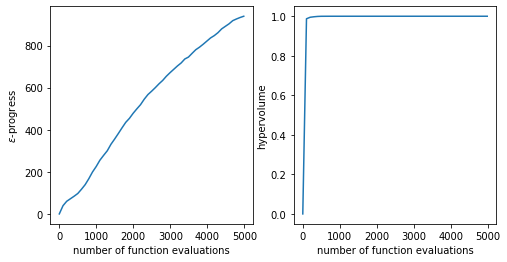

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## 3.4.2 Robust Analysis

In [8]:
results= pickle.load(
    open('results/MORO_evaluate_50.pkl', 'rb'))

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
new_results = experiments.join(outcome_total)
new_results = new_results.drop(columns="model")

#total demage calculate
damage_column=[]
death_column=[]
investment_column=[]
rfr_column = []
evacuation_column = []

for c in new_results.columns:
    if "Expected Annual Damage" in c:
        damage_column.append(c)

for c in new_results.columns:
    if "Expected Number of Deaths" in c:
        death_column.append(c)
        
for c in new_results.columns:
    if "Dike Investment Costs" in c:
        investment_column.append(c)
        
for c in new_results.columns:
    if "RfR Total Costs" in c:
        rfr_column.append(c)
        
for c in new_results.columns:
    if "Expected Evacuation Costs" in c:
        evacuation_column.append(c)

new_results["Total Expected Annual Damage"] = new_results[damage_column].sum(axis=1)
new_results["Total Expected Number of Deaths"] = new_results[death_column].sum(axis=1)
new_results["Total Dike Investment Costs"] = new_results[investment_column].sum(axis=1)
new_results["Total RfR Total Costs"] = new_results[rfr_column].sum(axis=1)
new_results["Total Expected Evacuation Costs"] = new_results[evacuation_column].sum(axis=1)

robustness_score = pd.DataFrame(columns = ["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"])

for p in new_results["policy"].unique():

    index = new_results[new_results["policy"] == p].index
    
    damage = robustness(new_results["Total Expected Annual Damage"][index])
    death = robustness(new_results["Total Expected Number of Deaths"][index])
    dike_invest = robustness(new_results["Total Dike Investment Costs"][index])
    rfr_cost = robustness(new_results["Total RfR Total Costs"][index])
    evacuation = robustness(new_results["Total Expected Evacuation Costs"][index])
    
        
    policy_line = [p, damage, death, dike_invest, rfr_cost, evacuation]
    
    robustness_score = robustness_score.append(pd.Series(policy_line, index=["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"]), ignore_index=True) 
    
robustness_score

,policy,damage,death,dike_invest,rfr_cost,evacuation
0,Policy 0,1.024697e+15,0.005266,1.114325e+09,2.139600e+09,4.220622e+06
1,Policy 1,3.830536e+14,0.001950,1.114325e+09,2.139600e+09,1.444826e+06
2,Policy 2,1.115267e+15,0.003395,1.114325e+09,2.139600e+09,3.086751e+06
3,Policy 3,4.688524e+14,0.002801,1.114325e+09,2.139600e+09,9.598915e+05
4,Policy 4,4.905272e+14,0.002574,1.114325e+09,2.139600e+09,1.583875e+06
...,...,...,...,...,...,...
262,Policy 262,4.955623e+12,0.000645,1.485257e+09,3.160600e+09,0.000000e+00
263,Policy 263,2.875992e+13,0.002245,1.485257e+09,3.160600e+09,0.000000e+00
264,Policy 264,1.518946e+13,0.001548,1.485257e+09,3.160600e+09,0.000000e+00
265,Policy 265,7.960337e+12,0.001113,1.485257e+09,3.160600e+09,0.000000e+00


In [14]:
results25, convergence25= pickle.load(
    open('results/MORO_50_nfe5000.pkl', 'rb'))
results25

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage,Deaths,Dike Invest,RfR Cost,Evacuation
0,0,1,0,0,0,0,0,1,0,0,...,5,4,3,1,6,5.664276e+15,0.005509,2.615005e+08,236500000.0,2.129533e+07
1,0,0,1,0,0,0,1,0,0,0,...,4,0,2,3,7,8.320005e+16,0.176534,1.628864e+08,115300000.0,0.000000e+00
2,0,0,0,0,0,0,0,0,0,0,...,2,5,0,0,0,9.256147e+16,0.078330,2.223327e+08,0.0,7.222064e+07
3,0,1,0,0,0,0,1,1,1,1,...,6,7,5,0,0,4.750114e+15,0.004689,2.272873e+08,297900000.0,1.784289e+07
4,0,1,0,0,0,0,0,0,0,0,...,4,2,5,0,1,8.508248e+15,0.005980,2.658587e+08,84600000.0,7.822052e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0,0,0,0,0,0,0,1,0,0,...,7,0,0,0,0,1.600512e+18,0.095400,9.531586e+07,30700000.0,4.951889e+08
263,0,0,0,1,0,0,0,0,0,0,...,0,3,0,0,1,2.281019e+17,0.043650,7.149908e+07,217800000.0,4.486243e+08
264,0,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,1.718381e+18,0.134367,6.613121e+07,0.0,3.634674e+08
265,0,0,0,0,0,0,1,0,0,0,...,6,3,0,0,0,1.610897e+18,0.376541,6.425384e+07,30700000.0,1.304890e+08


In [10]:
experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
new_results = experiments.join(outcome_total)
new_results = new_results.drop(columns="model")

#total demage calculate
damage_column=[]
death_column=[]
investment_column=[]
rfr_column = []
evacuation_column = []

for c in new_results.columns:
    if "Expected Annual Damage" in c:
        damage_column.append(c)

for c in new_results.columns:
    if "Expected Number of Deaths" in c:
        death_column.append(c)
        
for c in new_results.columns:
    if "Dike Investment Costs" in c:
        investment_column.append(c)
        
for c in new_results.columns:
    if "RfR Total Costs" in c:
        rfr_column.append(c)
        
for c in new_results.columns:
    if "Expected Evacuation Costs" in c:
        evacuation_column.append(c)

new_results["Total Expected Annual Damage"] = new_results[damage_column].sum(axis=1)
new_results["Total Expected Number of Deaths"] = new_results[death_column].sum(axis=1)
new_results["Total Dike Investment Costs"] = new_results[investment_column].sum(axis=1)
new_results["Total RfR Total Costs"] = new_results[rfr_column].sum(axis=1)
new_results["Total Expected Evacuation Costs"] = new_results[evacuation_column].sum(axis=1)

robustness_score = pd.DataFrame(columns = ["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"])

for p in new_results["policy"].unique():

    index = new_results[new_results["policy"] == p].index
    
    damage = robustness(new_results["Total Expected Annual Damage"][index])
    death = robustness(new_results["Total Expected Number of Deaths"][index])
    dike_invest = robustness(new_results["Total Dike Investment Costs"][index])
    rfr_cost = robustness(new_results["Total RfR Total Costs"][index])
    evacuation = robustness(new_results["Total Expected Evacuation Costs"][index])
    
        
    policy_line = [p, damage, death, dike_invest, rfr_cost, evacuation]
    
    robustness_score = robustness_score.append(pd.Series(policy_line, index=["policy", "damage", "death", "dike_invest", "rfr_cost", "evacuation"]), ignore_index=True) 
    
robustness_score

,policy,damage,death,dike_invest,rfr_cost,evacuation
0,Policy 0,1.024697e+15,0.005266,1.114325e+09,2.139600e+09,4.220622e+06
1,Policy 1,3.830536e+14,0.001950,1.114325e+09,2.139600e+09,1.444826e+06
2,Policy 2,1.115267e+15,0.003395,1.114325e+09,2.139600e+09,3.086751e+06
3,Policy 3,4.688524e+14,0.002801,1.114325e+09,2.139600e+09,9.598915e+05
4,Policy 4,4.905272e+14,0.002574,1.114325e+09,2.139600e+09,1.583875e+06
...,...,...,...,...,...,...
262,Policy 262,4.955623e+12,0.000645,1.485257e+09,3.160600e+09,0.000000e+00
263,Policy 263,2.875992e+13,0.002245,1.485257e+09,3.160600e+09,0.000000e+00
264,Policy 264,1.518946e+13,0.001548,1.485257e+09,3.160600e+09,0.000000e+00
265,Policy 265,7.960337e+12,0.001113,1.485257e+09,3.160600e+09,0.000000e+00


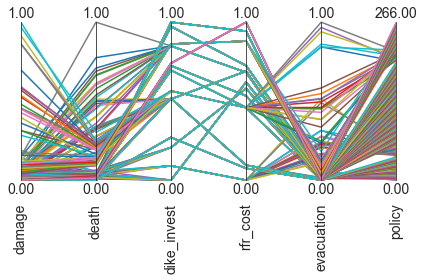

,policy,damage,death,dike_invest,rfr_cost,evacuation
0,Policy 0,1.024697e+15,0.005266,1.114325e+09,2.139600e+09,4.220622e+06
1,Policy 1,3.830536e+14,0.001950,1.114325e+09,2.139600e+09,1.444826e+06
2,Policy 2,1.115267e+15,0.003395,1.114325e+09,2.139600e+09,3.086751e+06
3,Policy 3,4.688524e+14,0.002801,1.114325e+09,2.139600e+09,9.598915e+05
4,Policy 4,4.905272e+14,0.002574,1.114325e+09,2.139600e+09,1.583875e+06
...,...,...,...,...,...,...
262,Policy 262,4.955623e+12,0.000645,1.485257e+09,3.160600e+09,0.000000e+00
263,Policy 263,2.875992e+13,0.002245,1.485257e+09,3.160600e+09,0.000000e+00
264,Policy 264,1.518946e+13,0.001548,1.485257e+09,3.160600e+09,0.000000e+00
265,Policy 265,7.960337e+12,0.001113,1.485257e+09,3.160600e+09,0.000000e+00


In [11]:
from ema_workbench.analysis import parcoords
robustness_new = robustness_score.drop(columns="policy")
data_norm = (robustness_new - robustness_new.min()) / (robustness_new.max() - robustness_new.min())
# Added the policy column as it helps as a 'legend'
data_norm["policy"] = data_norm.index
limits = parcoords.get_limits(data_norm)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_norm)
plt.show()
robustness_score


In [13]:
robustness_score[robustness_score["policy"] == "Policy 99"]

,policy,damage,death,dike_invest,rfr_cost,evacuation
99,Policy 99,4.644895e+14,0.001478,1.474419e+09,2.025600e+09,1.621756e+06


In [16]:
results25.iloc[98]

0_RfR 0               0.000000e+00
0_RfR 1               0.000000e+00
0_RfR 2               0.000000e+00
1_RfR 0               0.000000e+00
1_RfR 1               0.000000e+00
1_RfR 2               0.000000e+00
2_RfR 0               0.000000e+00
2_RfR 1               0.000000e+00
2_RfR 2               1.000000e+00
3_RfR 0               0.000000e+00
3_RfR 1               0.000000e+00
3_RfR 2               0.000000e+00
4_RfR 0               0.000000e+00
4_RfR 1               0.000000e+00
4_RfR 2               0.000000e+00
EWS_DaysToThreat      1.000000e+00
A.1_DikeIncrease 0    2.000000e+00
A.1_DikeIncrease 1    0.000000e+00
A.1_DikeIncrease 2    0.000000e+00
A.2_DikeIncrease 0    0.000000e+00
A.2_DikeIncrease 1    0.000000e+00
A.2_DikeIncrease 2    0.000000e+00
A.3_DikeIncrease 0    7.000000e+00
A.3_DikeIncrease 1    0.000000e+00
A.3_DikeIncrease 2    0.000000e+00
A.4_DikeIncrease 0    1.000000e+00
A.4_DikeIncrease 1    2.000000e+00
A.4_DikeIncrease 2    4.000000e+00
A.5_DikeIncrease 0  

In [46]:
policy99 = new_results[new_results["policy"] == "Policy 99"]

In [37]:
print(*policy99.columns, sep='\n')

A.0_ID flood wave shape
A.1_Bmax
A.1_Brate
A.1_pfail
A.2_Bmax
A.2_Brate
A.2_pfail
A.3_Bmax
A.3_Brate
A.3_pfail
A.4_Bmax
A.4_Brate
A.4_pfail
A.5_Bmax
A.5_Brate
A.5_pfail
discount rate 0
discount rate 1
discount rate 2
0_RfR 0
0_RfR 1
0_RfR 2
1_RfR 0
1_RfR 1
1_RfR 2
2_RfR 0
2_RfR 1
2_RfR 2
3_RfR 0
3_RfR 1
3_RfR 2
4_RfR 0
4_RfR 1
4_RfR 2
EWS_DaysToThreat
A.1_DikeIncrease 0
A.1_DikeIncrease 1
A.1_DikeIncrease 2
A.2_DikeIncrease 0
A.2_DikeIncrease 1
A.2_DikeIncrease 2
A.3_DikeIncrease 0
A.3_DikeIncrease 1
A.3_DikeIncrease 2
A.4_DikeIncrease 0
A.4_DikeIncrease 1
A.4_DikeIncrease 2
A.5_DikeIncrease 0
A.5_DikeIncrease 1
A.5_DikeIncrease 2
scenario
policy
A.1_Expected Annual Damage 0
A.1_Dike Investment Costs 0
A.1_Expected Number of Deaths 0
A.2_Expected Annual Damage 0
A.2_Dike Investment Costs 0
A.2_Expected Number of Deaths 0
A.3_Expected Annual Damage 0
A.3_Dike Investment Costs 0
A.3_Expected Number of Deaths 0
A.4_Expected Annual Damage 0
A.4_Dike Investment Costs 0
A.4_Expected Number o

In [49]:
base_damage = [[355125182.61733544, 50715999.84645771, 132122001.79553422, 5888394.024567844, 23066239.240156006], 
               [356677389.3222748, 51322983.844300754, 128138638.57111664, 5914134.02125824, 23620981.79066198], 
               [355922400.5782887, 51594901.78099206, 130599565.90792029, 5724818.063779456, 22971501.38923983]]
base_deaths = [[0.24410375180259933, 0.04593145092856825, 0.22664886664165118, 0.0025775558229184747, 0.020760454665878662], 
               [0.24410375180259933, 0.04593145092856825, 0.22664886664165118, 0.0025775558229184747, 0.020760454665878662], 
               [0.24410375180259933, 0.04593145092856825, 0.22664886664165118, 0.0025775558229184747, 0.020760454665878662]]
base_damage_mean = 6797620531.175535
base_deaths_mean = 6.48026495833939

No handles with labels found to put in legend.


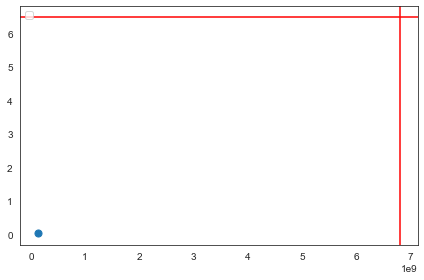

In [59]:
totaldamage = policy99["Total Expected Annual Damage"].mean()
totaldeath = policy99["Total Expected Number of Deaths"].mean()
plt.scatter(policy99["Total Expected Annual Damage"].mean(), policy99["Total Expected Number of Deaths"].mean(), s= 50)
plt.axhline(y=base_deaths_mean, color='red')
plt.axvline(x=base_damage_mean, color='red')
#plt.set_xlabel('Expected Annual Damage', fontsize=13)
#plt.set_ylabel('Expected Number of Deaths', fontsize=13)    
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


Time step:0


No handles with labels found to put in legend.


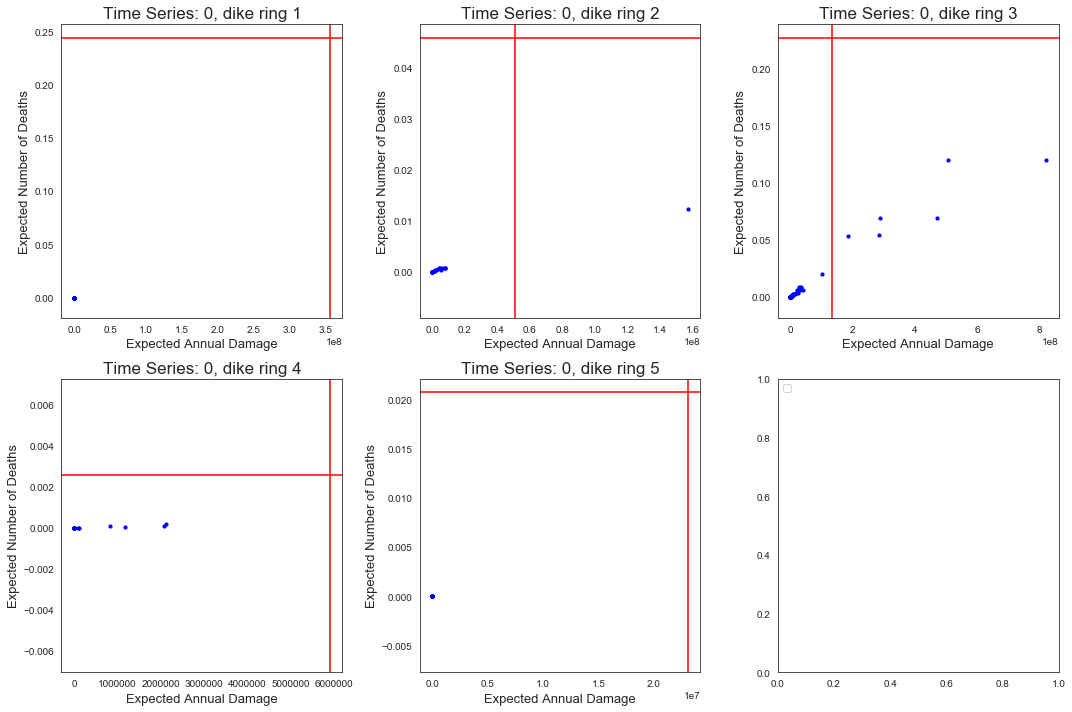

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

print("Time step:" + str(0))
for (i, a) in zip(range(5), axes.ravel()):
    a.scatter(policy99.iloc[:,52+3*i], policy99.iloc[:,52+3*i+2], s=10, c='b', marker="o", label='dike'+str(i+1))
    
    a.set_title("Time Series: 0, dike ring "+str(i+1), fontsize=17)
#    a.legend(loc='upper left')
    a.axhline(y=base_deaths[0][i], color='red')
    a.axvline(x=base_damage[0][i], color='red')
    

    a.set_xlabel('Expected Annual Damage', fontsize=13)
    a.set_ylabel('Expected Number of Deaths', fontsize=13)
    
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


Time step:1


No handles with labels found to put in legend.


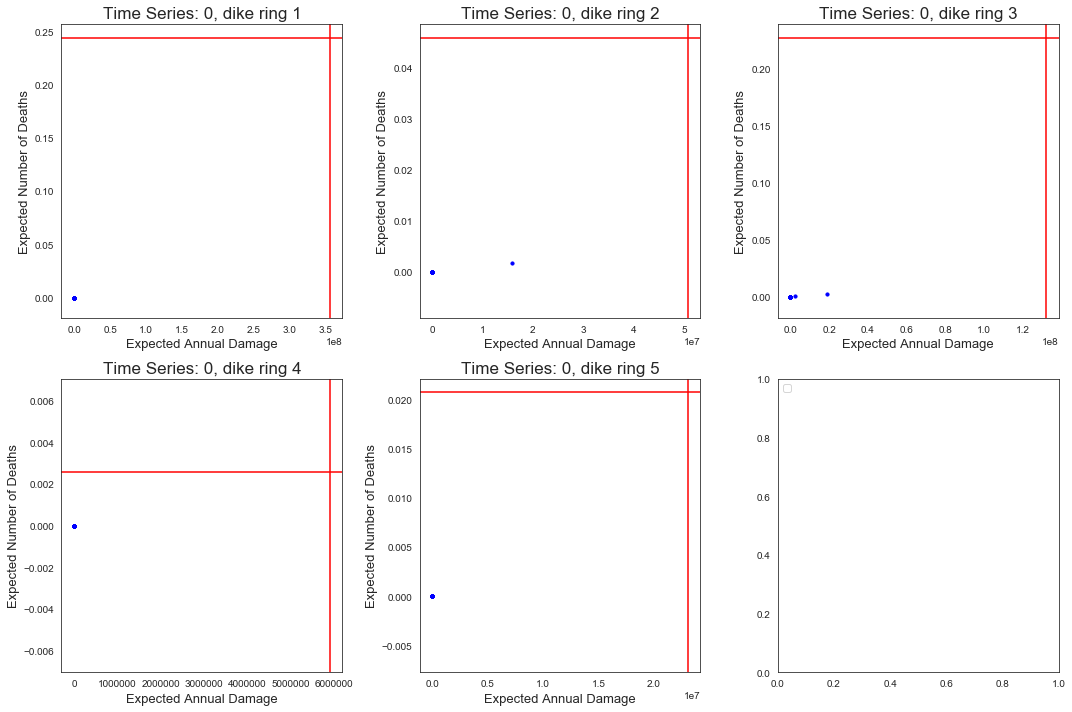

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

print("Time step:" + str(1))
for (i, a) in zip(range(5), axes.ravel()):
    a.scatter(policy99.iloc[:,69+3*i], policy99.iloc[:,69+3*i+2], s=10, c='b', marker="o", label='dike'+str(i+1))
    
    a.set_title("Time Series: 0, dike ring "+str(i+1), fontsize=17)
#    a.legend(loc='upper left')
    a.axhline(y=base_deaths[0][i], color='red')
    a.axvline(x=base_damage[0][i], color='red')
    

    a.set_xlabel('Expected Annual Damage', fontsize=13)
    a.set_ylabel('Expected Number of Deaths', fontsize=13)
    
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()


Time step:2


No handles with labels found to put in legend.


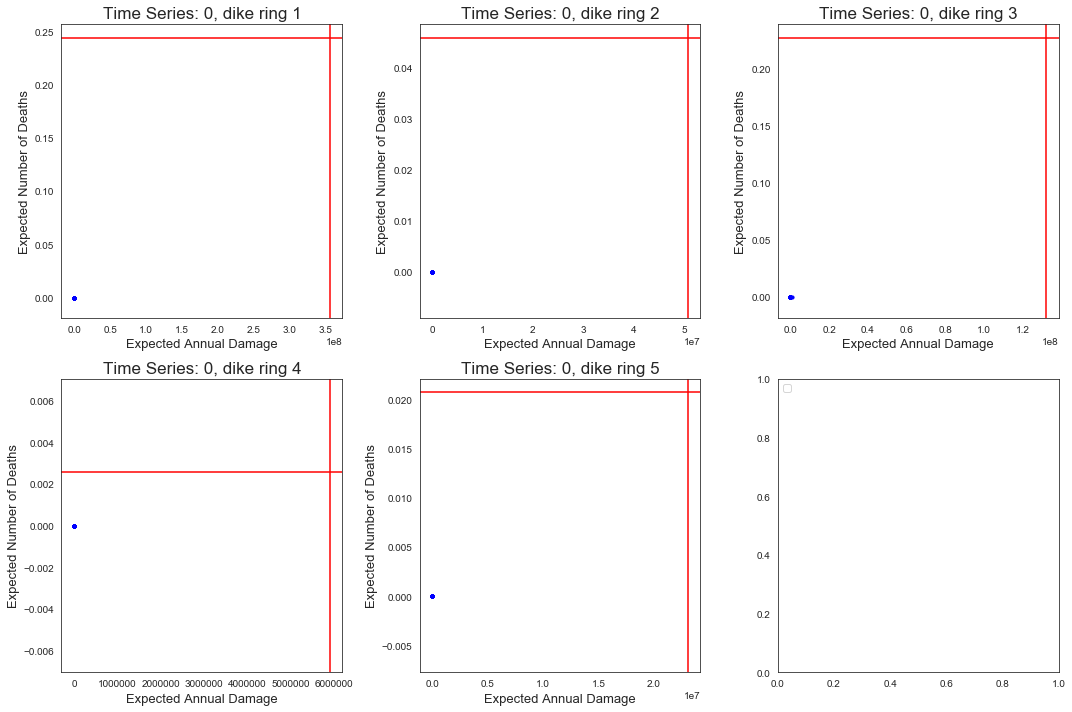

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

print("Time step:" + str(2))
for (i, a) in zip(range(5), axes.ravel()):
    a.scatter(policy99.iloc[:,86+3*i], policy99.iloc[:,86+3*i+2], s=10, c='b', marker="o", label='dike'+str(i+1))
    
    a.set_title("Time Series: 0, dike ring "+str(i+1), fontsize=17)
#    a.legend(loc='upper left')
    a.axhline(y=base_deaths[0][i], color='red')
    a.axvline(x=base_damage[0][i], color='red')
    

    a.set_xlabel('Expected Annual Damage', fontsize=13)
    a.set_ylabel('Expected Number of Deaths', fontsize=13)
    
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()
